# Denoising

In [48]:
import zarr
import zarr.storage
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import stft
from scipy.signal import find_peaks
from collections import defaultdict
from scipy.ndimage import median_filter

In [49]:
# List of shot IDs
shot_ids = [23447, 30005, 30021, 30421]  # Add more as needed

# S3 endpoint
endpoint = "https://s3.echo.stfc.ac.uk"
fs = fsspec.filesystem(
    protocol='simplecache',
    target_protocol="s3",
    target_options=dict(anon=True, endpoint_url=endpoint)
)

In [50]:
store_list = []
zgroup_list = []

# Loop through each shot ID
for shot_id in shot_ids:
    url = f"s3://mast/level2/shots/{shot_id}.zarr"
    
    store = zarr.storage.FSStore(fs=fs, url=url)
    store_list.append(store)
    # open or download the Zarr group
    try:
        zgroup_list.append(zarr.open(store, mode='r'))
        print(f"Loaded shot ID {shot_id}")
        # Do something with zgroup here, like listing arrays:
        # print(list(zgroup.array_keys()))
    except Exception as e:
        print(f"Failed to load shot ID {shot_id}: {e}")

Loaded shot ID 23447
Loaded shot ID 30005
Loaded shot ID 30021
Loaded shot ID 30421


In [51]:
mirnov = [xr.open_zarr(store, group="magnetics") for store in store_list]
ds_list = [m['b_field_pol_probe_omv_voltage'].isel(b_field_pol_probe_omv_channel=1) for m in mirnov]

In [52]:
def plot_stft_spectrogram(    ds,    shot_id=None,    nperseg=2000,    nfft=2000,    tmin=0.1,    tmax=0.46,    fmax_kHz=50,    cmap='jet'):
    """
    Plot STFT spectrogram for a given xarray DataArray `ds`.
    
    Parameters:
    - ds: xarray.DataArray with a 'time_mirnov' coordinate.
    - shot_id: Optional shot ID for labeling.
    - nperseg: Number of points per STFT segment.
    - nfft: Number of FFT points.
    - tmin, tmax: Time range to display (seconds).
    - fmax_kHz: Max frequency to display (kHz).
    - cmap: Colormap name.
    """
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap(cmap, 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, fmax_kHz)
    ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    title = f"STFT Spectrogram"
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label='Amplitude')
    plt.tight_layout()

[None, None, None, None]

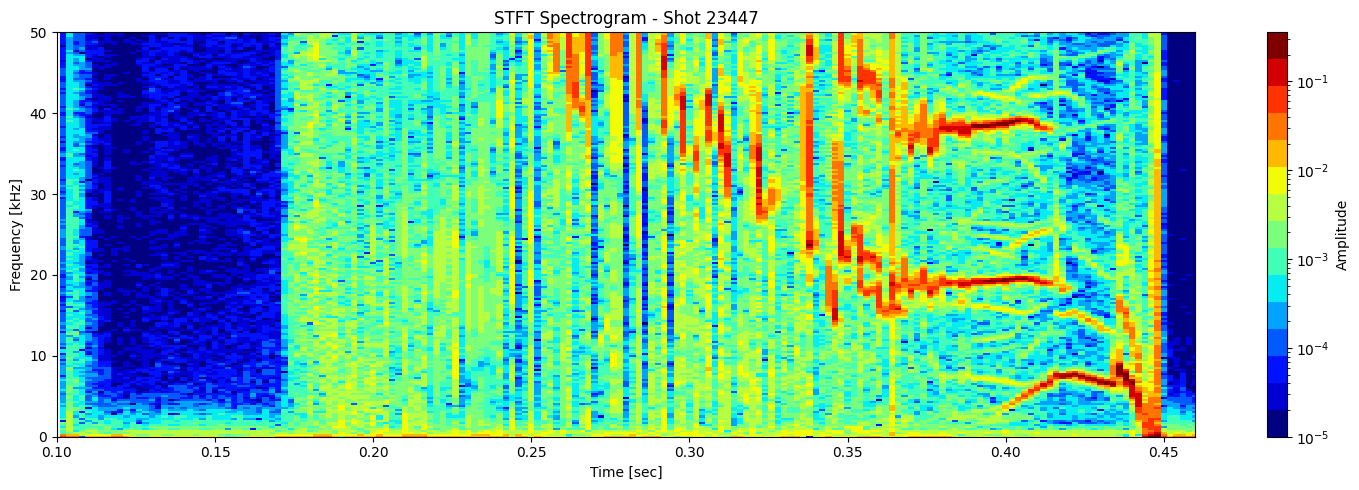

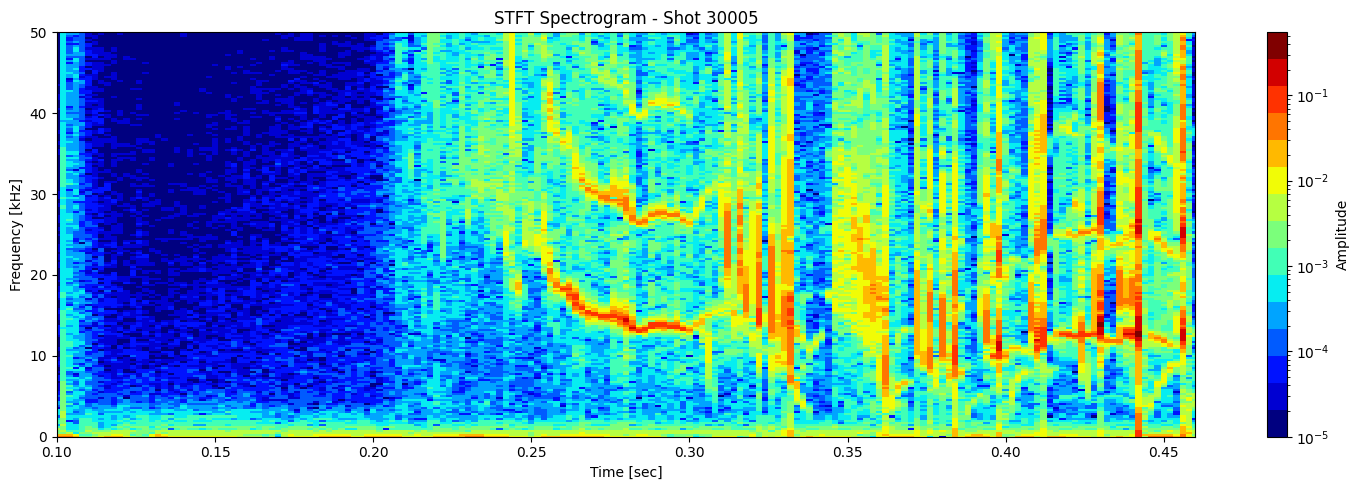

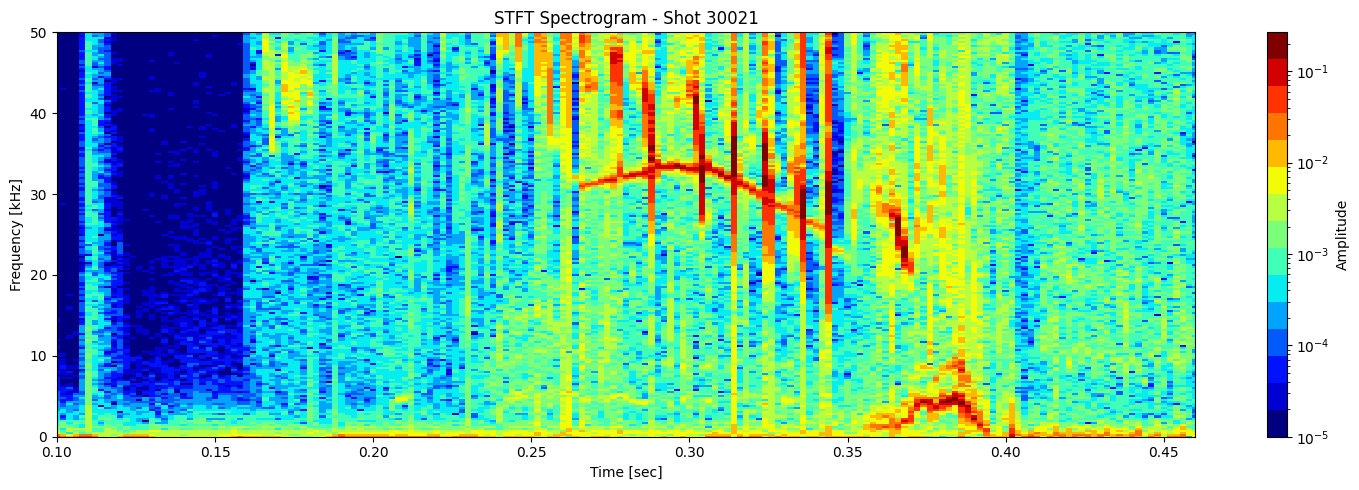

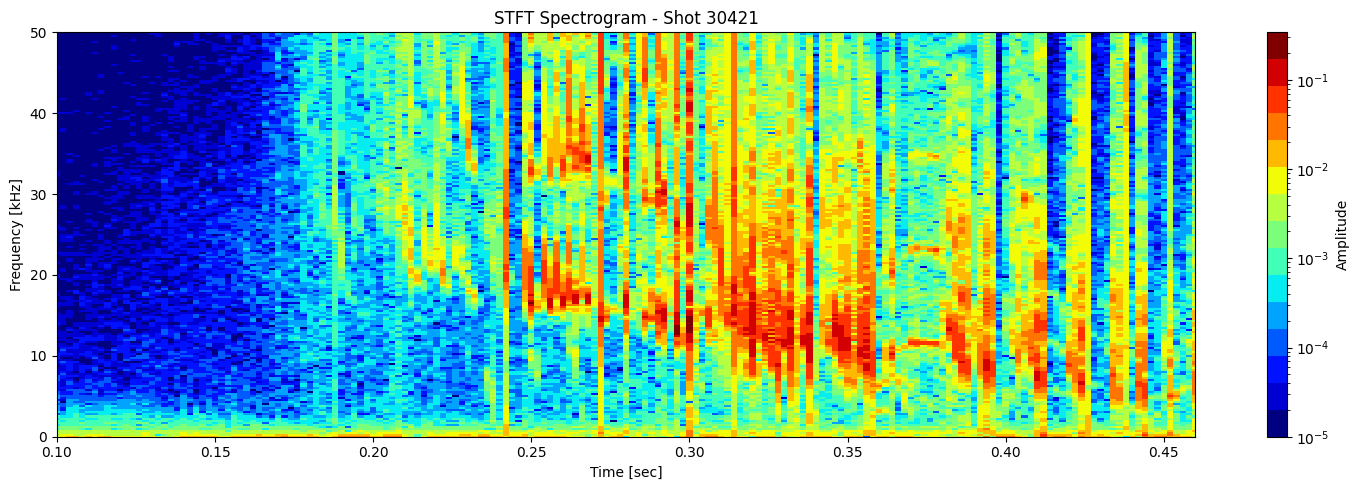

In [53]:
[plot_stft_spectrogram(ds_list[i], shot_ids[i]) for i in range(len(ds_list))]

In [54]:
def extract_ridges_from_stft(Zxx, f, t, amp_thresh=1e-3, delta_f_max=3000, min_ridge_len=10):
    """
    Track ridges from the STFT matrix by linking peaks across time with constraints.
    
    Parameters:
    - Zxx: STFT complex matrix (f x t)
    - f: frequency array (Hz)
    - t: time array (sec)
    - amp_thresh: minimum amplitude to consider a peak
    - delta_f_max: max frequency jump allowed (Hz)
    - min_ridge_len: minimum number of points for a valid ridge

    Returns:
    - List of ridges, each a list of (time, freq, amplitude)
    """
    num_t = len(t)
    num_f = len(f)
    
    # Convert to magnitude
    mag = np.abs(Zxx)
    mag_filtered = median_filter(mag, size=(5, 3))  # (freq_window, time_window)
    mag = mag_filtered
    amp_thresh = np.quantile(mag, 0.995)  # top 0.5% as candidate peaks


    # detect peaks in each time slice
    peaks_by_time = []
    for i in range(num_t):
        peaks, _ = find_peaks(mag[:, i], height=amp_thresh)
        peaks_by_time.append([(f[p], mag[p, i]) for p in peaks])

    # ridge linking
    ridges = []
    active_tracks = []

    for i in range(num_t):
        current_peaks = peaks_by_time[i]
        new_tracks = []
        
        for freq, amp in current_peaks:
            matched = False
            for track in active_tracks:
                # if abs(freq - track[-1][1]) < delta_f_max:
                #     track.append((t[i], freq, amp))
                prev_freqs = [pt[1] for pt in track[-2:]]
                if len(prev_freqs) == 2:
                    slope = prev_freqs[1] - prev_freqs[0]
                    f_pred = prev_freqs[1] + slope
                    if abs(freq - f_pred) < delta_f_max:
                        track.append((t[i], freq, amp))
                        matched = True

                    # matched = True
                    break
            if not matched:
                new_tracks.append([(t[i], freq, amp)])

        # Keep long enough tracks
        active_tracks = [trk for trk in active_tracks if len(trk) >= min_ridge_len] + new_tracks

    # Final cleanup
    ridges = [trk for trk in ridges if len(trk) >= min_ridge_len and np.mean([a for _, _, a in trk]) > 0.005]

    #ridges = [trk for trk in active_tracks if len(trk) >= min_ridge_len]
    return ridges
# Plotting Function
def plot_ridges_on_spectrogram(ridges, ax, color='white'):
    for ridge in ridges:
        t_vals, f_vals, _ = zip(*ridge)
        ax.plot(t_vals, np.array(f_vals) / 1000, color=color, linewidth=1)


In [55]:
def extract_clean_ridges_from_stft(
    Zxx, f, t,
    amp_thresh=1e-3,
    delta_f_max=3000,
    max_gap=2,
    min_ridge_len=10
):
    """
    Improved ridge tracking with slope prediction, amplitude continuity,
    and peak ownership to avoid mode jumping.

    Parameters:
    - Zxx: STFT (f x t) complex matrix
    - f: frequency array (Hz)
    - t: time array (sec)
    - amp_thresh: minimum amplitude to consider a peak
    - delta_f_max: max frequency jump (Hz)
    - max_gap: maximum time steps a track can go without a match
    - min_ridge_len: minimum track length to keep

    Returns:
    - List of ridges: each is a list of (time, freq, amp)
    """
    mag = np.abs(Zxx)
    num_t = len(t)
    num_f = len(f)

    # Step 1: Detect peaks
    peaks_by_time = []
    for i in range(num_t):
        peaks, props = find_peaks(mag[:, i], height=amp_thresh)
        peak_data = [(f[p], mag[p, i]) for p in peaks]
        peaks_by_time.append(peak_data)

    # Step 2: Track structures
    active_tracks = []
    finished_tracks = []

    for i in range(num_t):
        used_peaks = set()
        new_tracks = []

        # Try to extend each active track
        for track in active_tracks:
            if len(track['data']) < 2:
                f_pred = track['data'][-1][1]
            else:
                f_pred = 2 * track['data'][-1][1] - track['data'][-2][1]

            best_match = None
            best_cost = float('inf')

            for j, (f_cand, amp_cand) in enumerate(peaks_by_time[i]):
                if j in used_peaks:
                    continue
                if abs(f_cand - f_pred) < delta_f_max:
                    amp_prev = track['data'][-1][2]
                    cost = abs(f_cand - f_pred) + 1000 * abs(amp_cand - amp_prev)
                    if cost < best_cost:
                        best_cost = cost
                        best_match = (j, f_cand, amp_cand)

            if best_match is not None:
                j, f_cand, amp_cand = best_match
                track['data'].append((t[i], f_cand, amp_cand))
                track['last_seen'] = i
                used_peaks.add(j)
                new_tracks.append(track)
            elif i - track['last_seen'] <= max_gap:
                # Continue track with no match
                new_tracks.append(track)
            else:
                if len(track['data']) >= min_ridge_len:
                    finished_tracks.append(track['data'])

        # Start new tracks from unmatched peaks
        for j, (f_cand, amp_cand) in enumerate(peaks_by_time[i]):
            if j not in used_peaks:
                new_tracks.append({
                    'data': [(t[i], f_cand, amp_cand)],
                    'last_seen': i
                })

        active_tracks = new_tracks

    # Append remaining active tracks
    for track in active_tracks:
        if len(track['data']) >= min_ridge_len:
            finished_tracks.append(track['data'])

    return finished_tracks


Processing signal 1/4
→ Number of ridges detected: 562


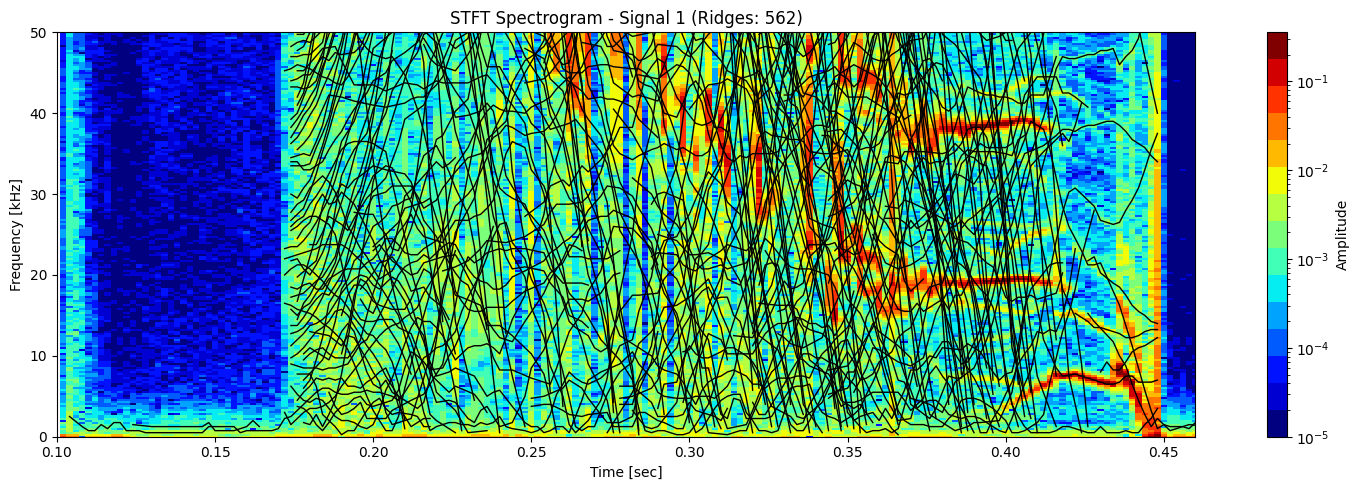

Processing signal 2/4
→ Number of ridges detected: 350


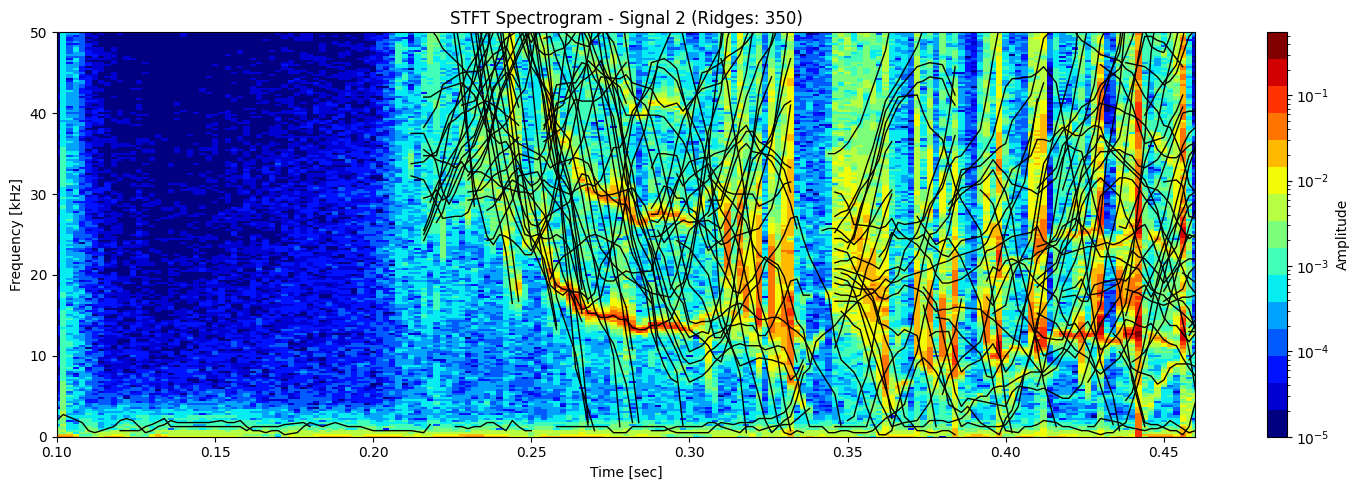

Processing signal 3/4
→ Number of ridges detected: 688


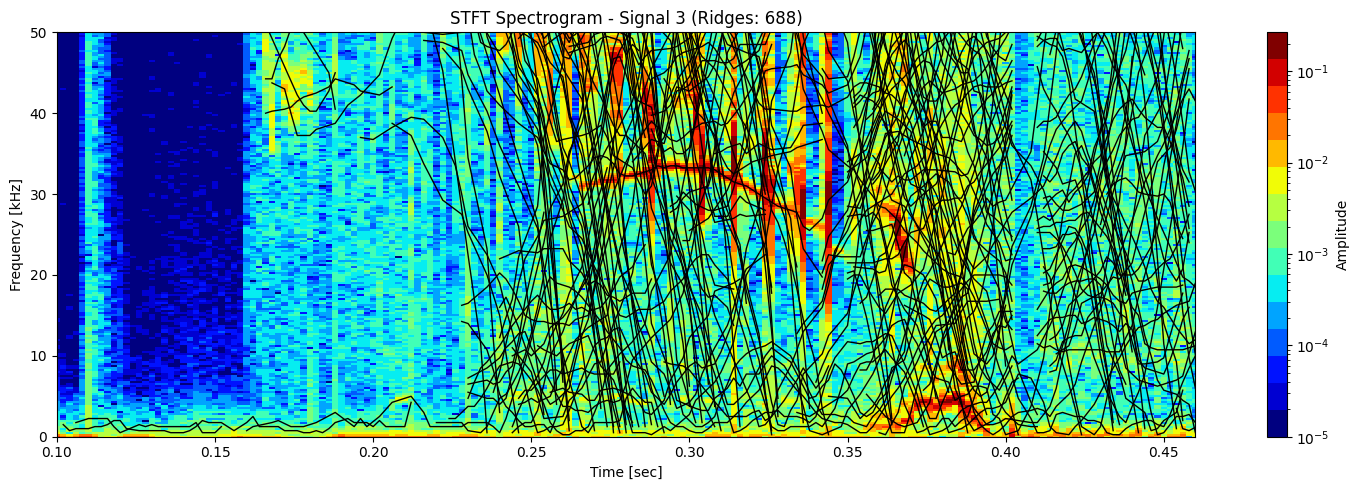

Processing signal 4/4
→ Number of ridges detected: 398


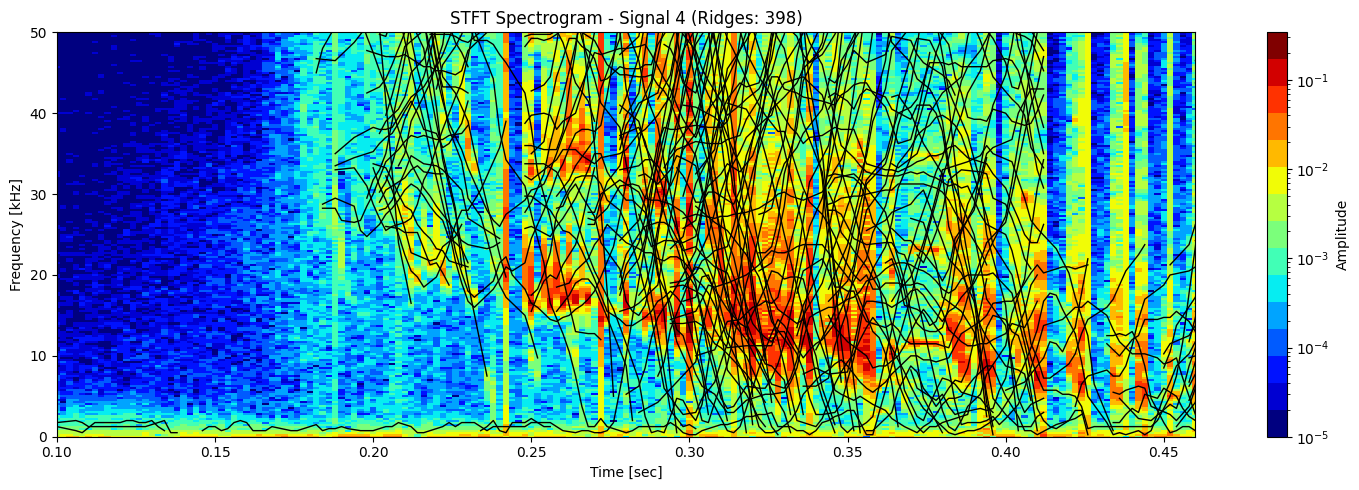

In [56]:
nperseg = 2000
nfft = 2000

for i, ds in enumerate(ds_list):
    print(f"Processing signal {i+1}/{len(ds_list)}")

    # Compute sample rate
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])

    # Compute STFT
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    # Extract ridges
    ridges = extract_clean_ridges_from_stft(Zxx, f, t)

    # Print ridge count
    print(f"→ Number of ridges detected: {len(ridges)}")

    # Plot
    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap('jet', 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, 50)
    ax.set_xlim(0.1, 0.46)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(f"STFT Spectrogram - Signal {i+1} (Ridges: {len(ridges)})")
    fig.colorbar(cax, ax=ax, label='Amplitude')
    plot_ridges_on_spectrogram(ridges, ax, color='black')
    plt.tight_layout()
    plt.show()


# Second try

In [57]:
def extract_clean_ridges_from_stft(
    Zxx, f, t,
    amp_thresh=1e-3,
    delta_f_max=3000,
    max_gap=2,
    min_ridge_len=10
):
    """
    Improved ridge tracking with slope prediction, amplitude continuity,
    and peak ownership to avoid mode jumping.

    Parameters:
    - Zxx: STFT (f x t) complex matrix
    - f: frequency array (Hz)
    - t: time array (sec)
    - amp_thresh: minimum amplitude to consider a peak
    - delta_f_max: max frequency jump (Hz)
    - max_gap: maximum time steps a track can go without a match
    - min_ridge_len: minimum track length to keep

    Returns:
    - List of ridges: each is a list of (time, freq, amp)
    """
    mag = np.abs(Zxx)
    num_t = len(t)
    num_f = len(f)

    #  Detect peaks
    peaks_by_time = []
    for i in range(num_t):
        peaks, props = find_peaks(mag[:, i], height=amp_thresh)
        peak_data = [(f[p], mag[p, i]) for p in peaks]
        peaks_by_time.append(peak_data)

    # Track structures
    active_tracks = []
    finished_tracks = []

    for i in range(num_t):
        used_peaks = set()
        new_tracks = []

        # Try to extend each active track
        for track in active_tracks:
            if len(track['data']) < 2:
                f_pred = track['data'][-1][1]
            else:
                f_pred = 2 * track['data'][-1][1] - track['data'][-2][1]

            best_match = None
            best_cost = float('inf')

            for j, (f_cand, amp_cand) in enumerate(peaks_by_time[i]):
                if j in used_peaks:
                    continue
                if abs(f_cand - f_pred) < delta_f_max:
                    amp_prev = track['data'][-1][2]
                    cost = abs(f_cand - f_pred) + 1000 * abs(amp_cand - amp_prev)
                    if cost < best_cost:
                        best_cost = cost
                        best_match = (j, f_cand, amp_cand)

            if best_match is not None:
                j, f_cand, amp_cand = best_match
                track['data'].append((t[i], f_cand, amp_cand))
                track['last_seen'] = i
                used_peaks.add(j)
                new_tracks.append(track)
            elif i - track['last_seen'] <= max_gap:
                # Continue track with no match
                new_tracks.append(track)
            else:
                if len(track['data']) >= min_ridge_len:
                    finished_tracks.append(track['data'])

        # Start new tracks from unmatched peaks
        for j, (f_cand, amp_cand) in enumerate(peaks_by_time[i]):
            if j not in used_peaks:
                new_tracks.append({
                    'data': [(t[i], f_cand, amp_cand)],
                    'last_seen': i
                })

        active_tracks = new_tracks

    # Append remaining active tracks
    for track in active_tracks:
        if len(track['data']) >= min_ridge_len:
            finished_tracks.append(track['data'])

    return finished_tracks

In [75]:
def extract_denoised_ridges_from_stft(
    Zxx, f, t,
    quantile_thresh=0.995,
    delta_f_max=3000,
    max_gap=2,
    min_ridge_len=10,
    min_avg_amp=0.005,
    median_filter_size=(5, 3)
):
    """
    Robust ridge tracker with spectrogram denoising, adaptive thresholding,
    slope prediction, and track filtering.

    Parameters:
    - Zxx: STFT complex matrix (f x t)
    - f: frequency array (Hz)
    - t: time array (sec)
    - quantile_thresh: amplitude threshold as quantile (e.g. 0.995)
    - delta_f_max: max frequency jump (Hz)
    - max_gap: max allowed time steps without match
    - min_ridge_len: minimum number of points for a valid ridge
    - min_avg_amp: minimum average amplitude for a valid ridge
    - median_filter_size: (freq_window, time_window) for denoising

    Returns:
    - List of ridges, each a list of (time, freq, amp)
    """
    mag = np.abs(Zxx)

    # Denoise spectrogram using median filtering
    mag = median_filter(mag, size=median_filter_size)

    # Adaptive amplitude threshold
    amp_thresh = np.quantile(mag, quantile_thresh)

    num_t = len(t)
    peaks_by_time = []
    for i in range(num_t):
        peaks, _ = find_peaks(mag[:, i], height=amp_thresh)
        peak_data = [(f[p], mag[p, i]) for p in peaks]
        peaks_by_time.append(peak_data)

    # Ridge tracking
    active_tracks = []
    finished_tracks = []

    for i in range(num_t):
        used_peaks = set()
        new_tracks = []

        for track in active_tracks:
            if len(track['data']) < 2:
                f_pred = track['data'][-1][1]
            else:
                f_pred = 2 * track['data'][-1][1] - track['data'][-2][1]

            best_match = None
            best_cost = float('inf')

            for j, (f_cand, amp_cand) in enumerate(peaks_by_time[i]):
                if j in used_peaks:
                    continue
                if abs(f_cand - f_pred) < delta_f_max:
                    amp_prev = track['data'][-1][2]
                    cost = abs(f_cand - f_pred) + 1000 * abs(amp_cand - amp_prev)
                    if cost < best_cost:
                        best_cost = cost
                        best_match = (j, f_cand, amp_cand)

            if best_match is not None:
                j, f_cand, amp_cand = best_match
                track['data'].append((t[i], f_cand, amp_cand))
                track['last_seen'] = i
                used_peaks.add(j)
                new_tracks.append(track)
            elif i - track['last_seen'] <= max_gap:
                new_tracks.append(track)
            else:
                finished_tracks.append(track['data'])

        # Start new tracks from unmatched peaks
        for j, (f_cand, amp_cand) in enumerate(peaks_by_time[i]):
            if j not in used_peaks:
                new_tracks.append({
                    'data': [(t[i], f_cand, amp_cand)],
                    'last_seen': i
                })

        active_tracks = new_tracks

    # Finalize all
    all_tracks = finished_tracks + [trk['data'] for trk in active_tracks]

    # Filter out junk
    final_ridges = [
        trk for trk in all_tracks
        if len(trk) >= min_ridge_len and np.mean([a for _, _, a in trk]) >= min_avg_amp
    ]

    return final_ridges

# def plot_ridges_on_spectrogram(ridges, ax, cmap='tab10'):
#     import matplotlib.pyplot as plt
#     colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(ridges)))
#     for idx, ridge in enumerate(ridges):
#         if len(ridge) >= 2:
#             t_vals, f_vals, _ = zip(*ridge)
#             ax.plot(t_vals, np.array(f_vals) / 1000, color=colors[idx], linewidth=1.5)


Processing signal 1/4
→ Number of ridges detected: 0


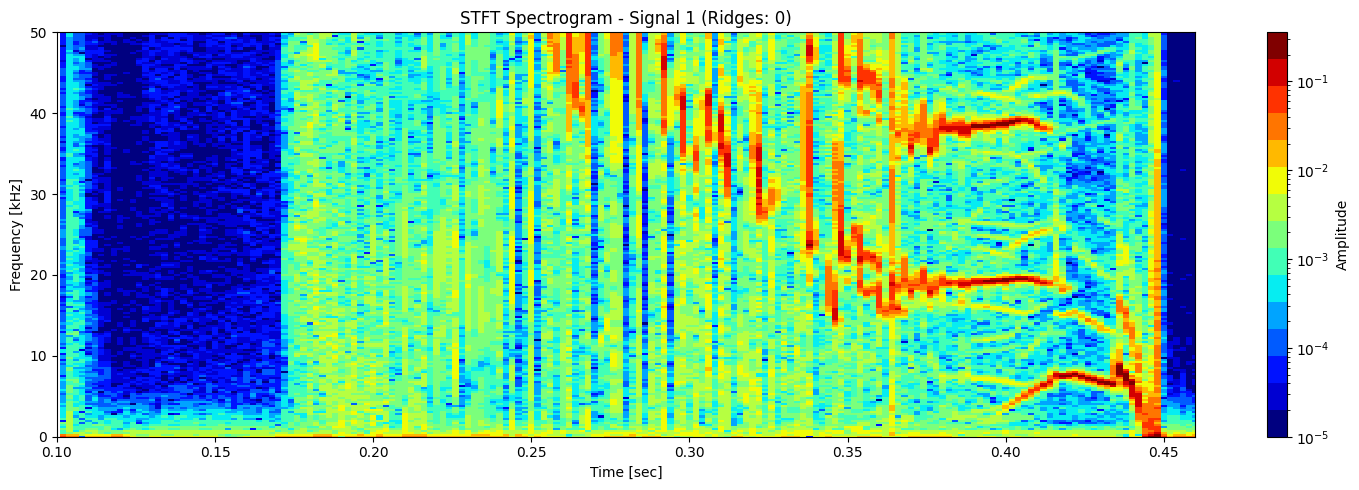

Processing signal 2/4
→ Number of ridges detected: 4


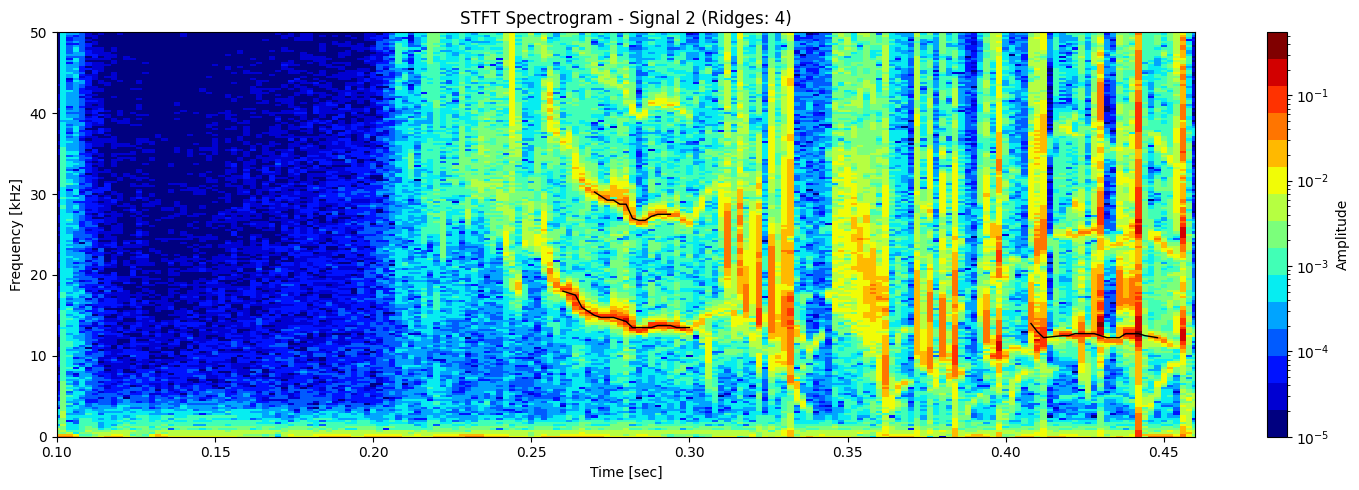

Processing signal 3/4
→ Number of ridges detected: 0


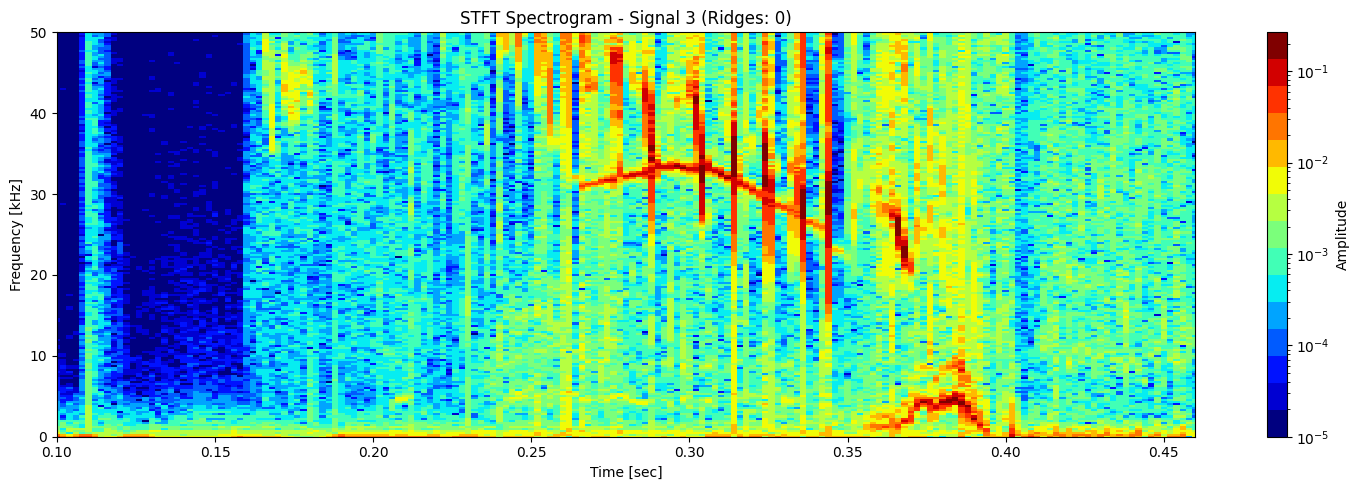

Processing signal 4/4
→ Number of ridges detected: 3


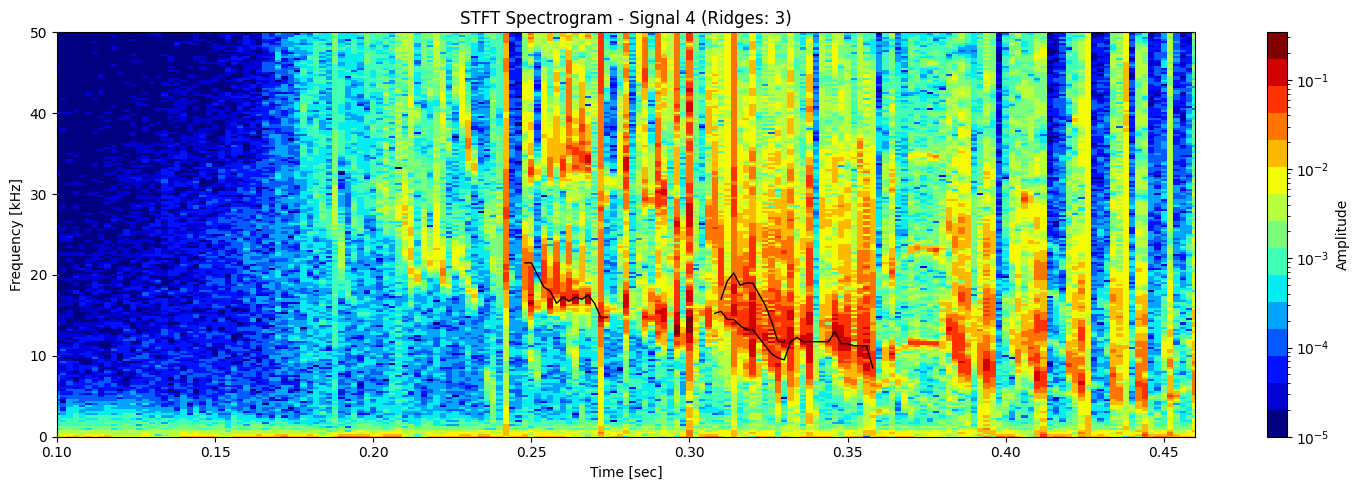

In [79]:
nperseg = 2000
nfft = 2000

for i, ds in enumerate(ds_list):
    print(f"Processing signal {i+1}/{len(ds_list)}")

    # Compute sample rate
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])

    # Compute STFT
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    # Extract ridges
    ridges = extract_denoised_ridges_from_stft(Zxx, f, t)
    # ridges = extract_denoised_ridges_from_stft(
    #     Zxx, f, t,
    #     quantile_thresh=0.98,
    #     delta_f_max=4000,
    #     max_gap=2,
    #     min_ridge_len=5,
    #     min_avg_amp=0.002,
    #     median_filter_size=(7, 5)
    # )
    # ridges = extract_denoised_ridges_from_stft(
    #     Zxx, f, t,
    #     quantile_thresh=0.975,     # lower threshold even more
    #     delta_f_max=5000,          # more forgiving frequency jump
    #     max_gap=3,                 # allow skipping over a few bad time slices
    #     min_ridge_len=4,           # allow shorter ridges
    #     min_avg_amp=0.0015,        # keep lower amplitude tracks
    #     median_filter_size=(5, 3)  # can stay as-is
    # )


    # Print ridge count
    print(f"→ Number of ridges detected: {len(ridges)}")

    # Plot
    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap('jet', 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, 50)
    ax.set_xlim(0.1, 0.46)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(f"STFT Spectrogram - Signal {i+1} (Ridges: {len(ridges)})")
    fig.colorbar(cax, ax=ax, label='Amplitude')
    plot_ridges_on_spectrogram(ridges, ax, color='black')
    plt.tight_layout()
    plt.show()


Processing signal 1/4
→ Number of ridges detected: 0


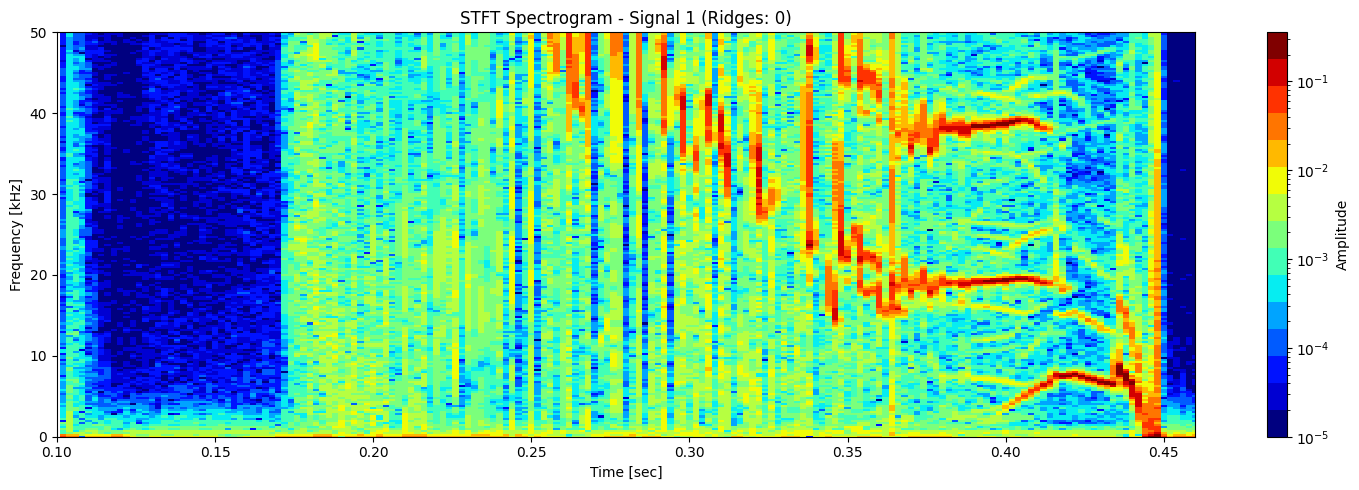

Processing signal 2/4
→ Number of ridges detected: 32


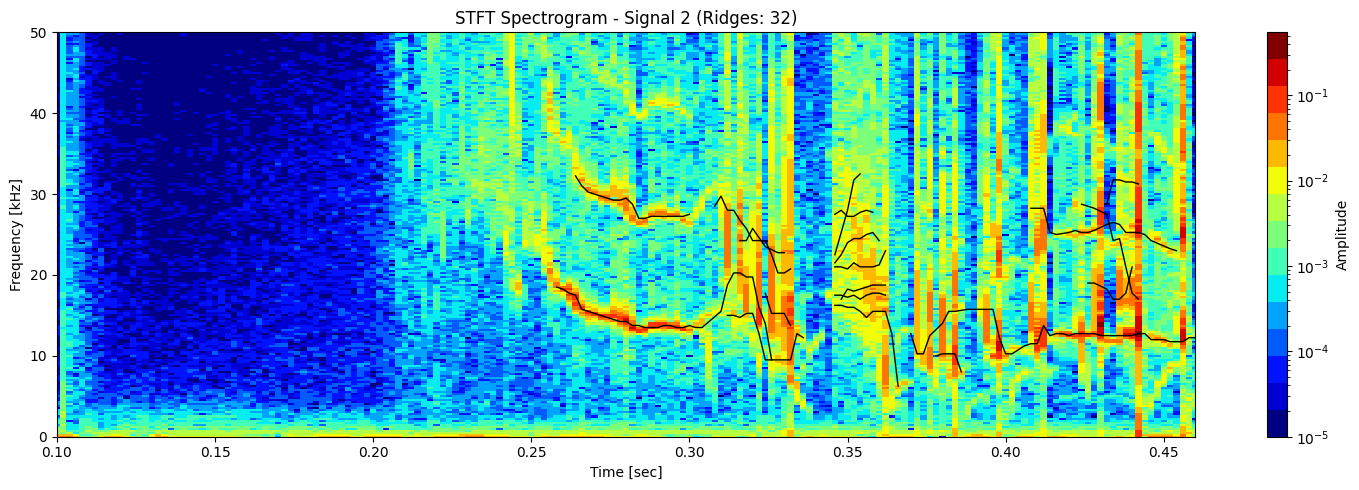

Processing signal 3/4
→ Number of ridges detected: 0


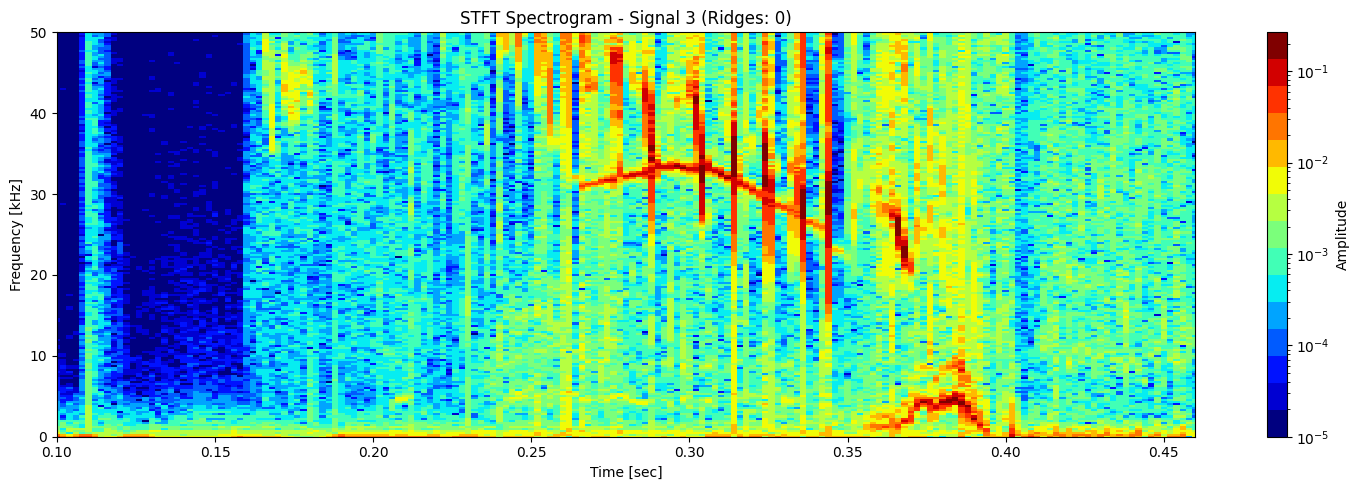

Processing signal 4/4
→ Number of ridges detected: 46


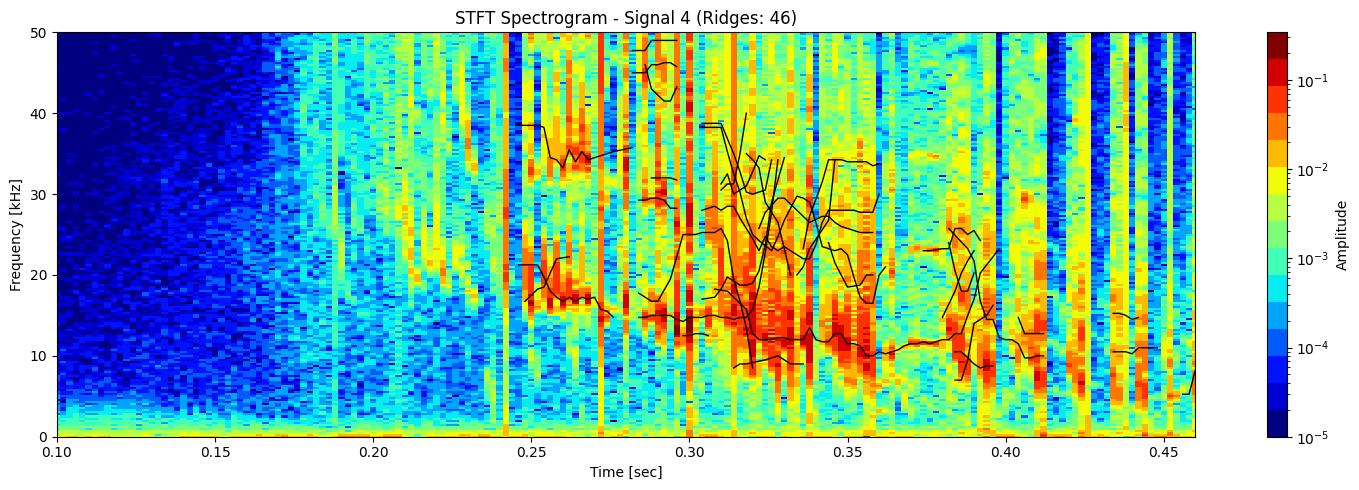

In [80]:
nperseg = 2000
nfft = 2000

for i, ds in enumerate(ds_list):
    print(f"Processing signal {i+1}/{len(ds_list)}")

    # Compute sample rate
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])

    # Compute STFT
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    # Extract ridges
    # ridges = extract_denoised_ridges_from_stft(Zxx, f, t)
    ridges = extract_denoised_ridges_from_stft(
        Zxx, f, t,
        quantile_thresh=0.98,
        delta_f_max=4000,
        max_gap=2,
        min_ridge_len=5,
        min_avg_amp=0.002,
        median_filter_size=(7, 5)
    )
    # ridges = extract_denoised_ridges_from_stft(
    #     Zxx, f, t,
    #     quantile_thresh=0.975,     # lower threshold even more
    #     delta_f_max=5000,          # more forgiving frequency jump
    #     max_gap=3,                 # allow skipping over a few bad time slices
    #     min_ridge_len=4,           # allow shorter ridges
    #     min_avg_amp=0.0015,        # keep lower amplitude tracks
    #     median_filter_size=(5, 3)  # can stay as-is
    # )


    # Print ridge count
    print(f"→ Number of ridges detected: {len(ridges)}")

    # Plot
    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap('jet', 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, 50)
    ax.set_xlim(0.1, 0.46)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(f"STFT Spectrogram - Signal {i+1} (Ridges: {len(ridges)})")
    fig.colorbar(cax, ax=ax, label='Amplitude')
    plot_ridges_on_spectrogram(ridges, ax, color='black')
    plt.tight_layout()
    plt.show()


Processing signal 1/4
→ Number of ridges detected: 0


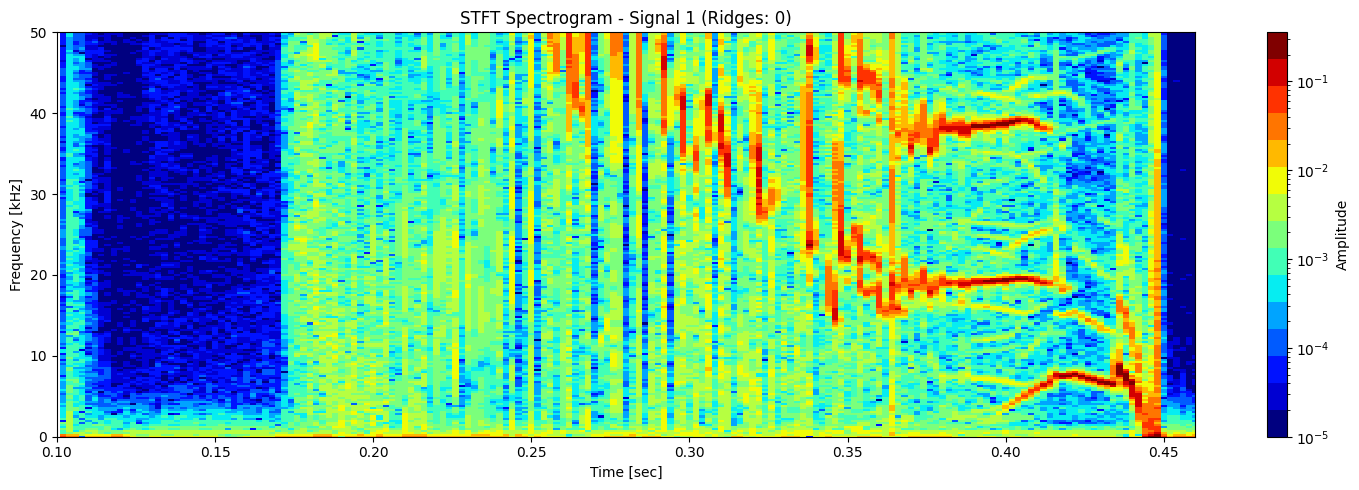

Processing signal 2/4
→ Number of ridges detected: 50


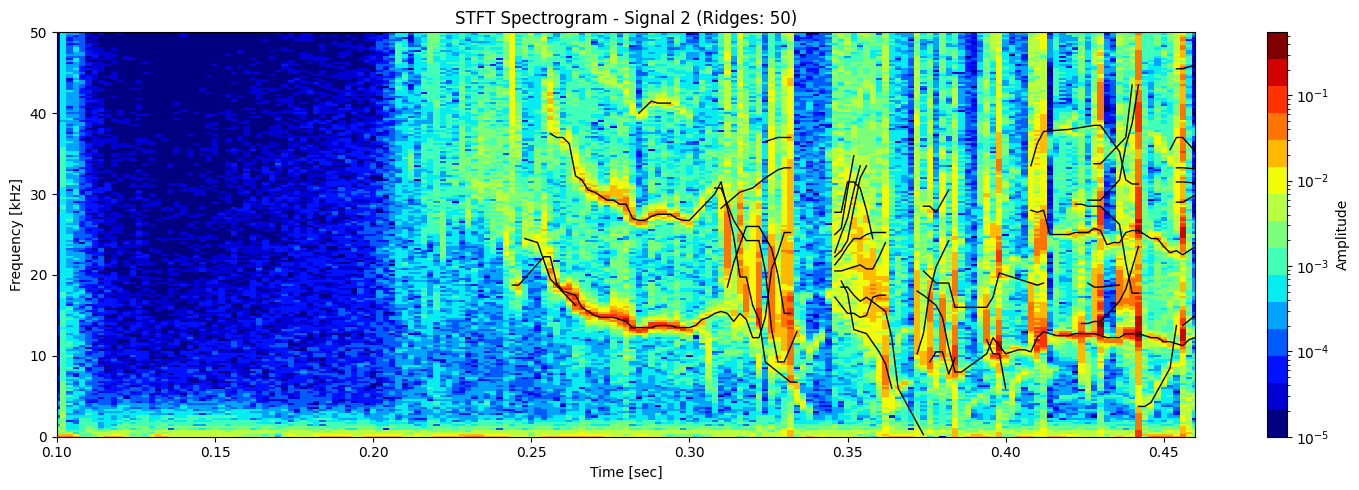

Processing signal 3/4
→ Number of ridges detected: 0


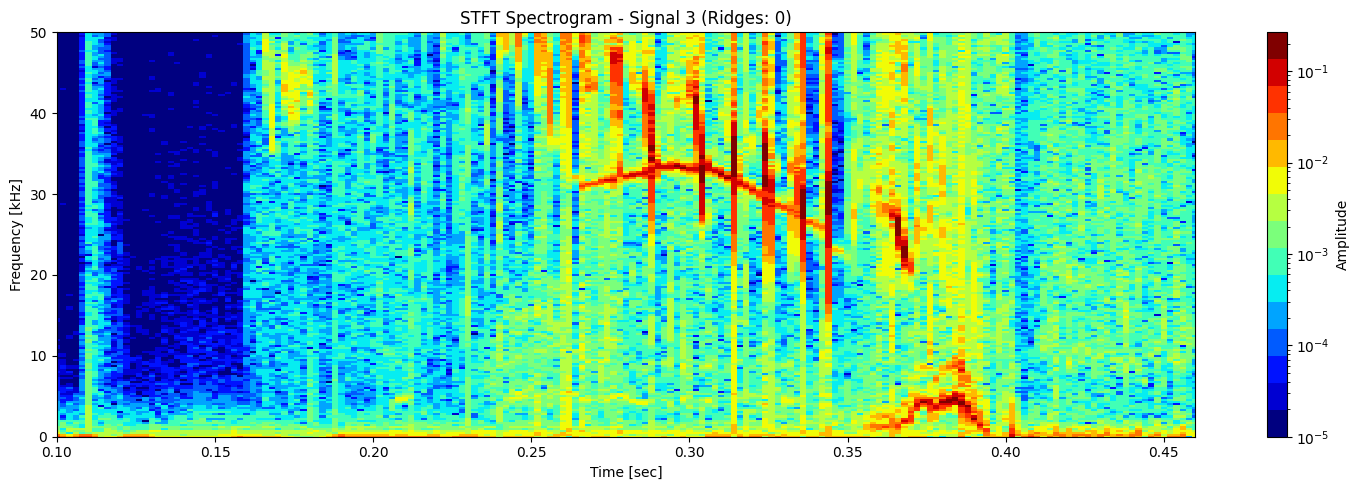

Processing signal 4/4
→ Number of ridges detected: 65


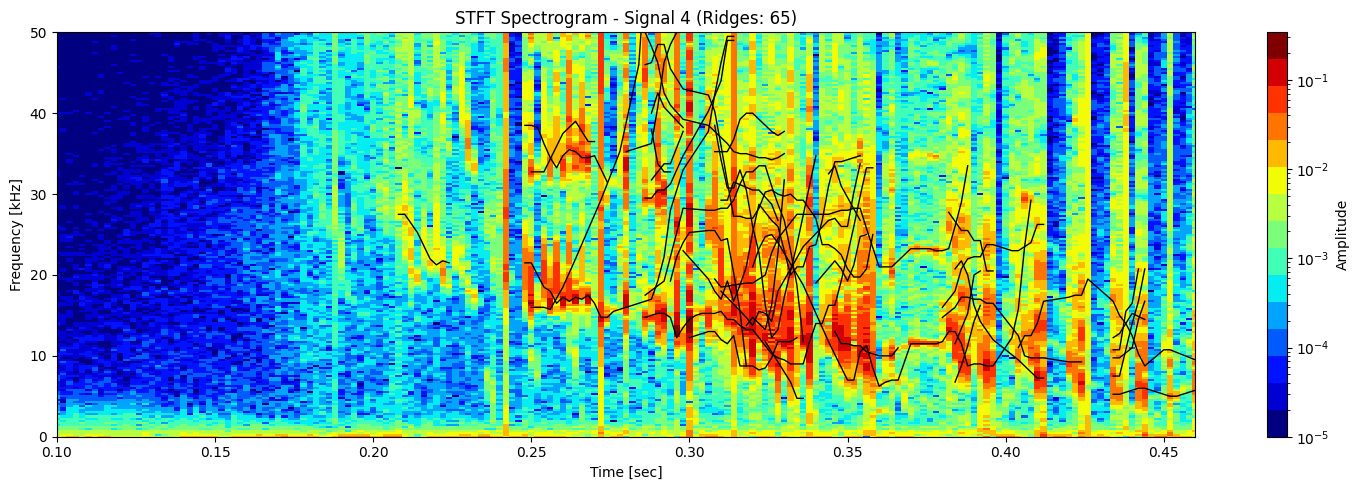

In [81]:
nperseg = 2000
nfft = 2000

for i, ds in enumerate(ds_list):
    print(f"Processing signal {i+1}/{len(ds_list)}")

    # Compute sample rate
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])

    # Compute STFT
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    # Extract ridges
    # ridges = extract_denoised_ridges_from_stft(Zxx, f, t)
    # ridges = extract_denoised_ridges_from_stft(
    #     Zxx, f, t,
    #     quantile_thresh=0.98,
    #     delta_f_max=4000,
    #     max_gap=2,
    #     min_ridge_len=5,
    #     min_avg_amp=0.002,
    #     median_filter_size=(7, 5)
    # )
    ridges = extract_denoised_ridges_from_stft(
        Zxx, f, t,
        quantile_thresh=0.975,     # lower threshold even more
        delta_f_max=5000,          # more forgiving frequency jump
        max_gap=3,                 # allow skipping over a few bad time slices
        min_ridge_len=4,           # allow shorter ridges
        min_avg_amp=0.0015,        # keep lower amplitude tracks
        median_filter_size=(5, 3)  # can stay as-is
    )


    # Print ridge count
    print(f"→ Number of ridges detected: {len(ridges)}")

    # Plot
    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap('jet', 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, 50)
    ax.set_xlim(0.1, 0.46)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(f"STFT Spectrogram - Signal {i+1} (Ridges: {len(ridges)})")
    fig.colorbar(cax, ax=ax, label='Amplitude')
    plot_ridges_on_spectrogram(ridges, ax, color='black')
    plt.tight_layout()
    plt.show()


In [82]:
def extract_denoised_ridges_from_stft(
    Zxx, f, t,
    quantile_thresh=0.98,
    fixed_amp_thresh=None,
    delta_f_max=4000,
    max_gap=2,
    min_ridge_len=4,
    min_avg_amp=1e-4,
    median_filter_size=(5, 3)
):
    """
    Ridge extraction with denoising and flexible amplitude thresholding.

    Parameters:
    - Zxx: STFT complex matrix (f x t)
    - f, t: frequency and time axes
    - quantile_thresh: quantile for adaptive amp threshold (ignored if fixed_amp_thresh is set)
    - fixed_amp_thresh: set a constant amplitude threshold (overrides quantile_thresh)
    - delta_f_max: max frequency jump allowed (Hz)
    - max_gap: max allowed time steps without match
    - min_ridge_len: min number of time points for a valid ridge
    - min_avg_amp: min average amplitude for a ridge to survive
    - median_filter_size: (f, t) smoothing kernel

    Returns:
    - List of ridges, each as a list of (time, frequency, amplitude)
    """
    mag = np.abs(Zxx)
    mag = median_filter(mag, size=median_filter_size)

    if fixed_amp_thresh is not None:
        amp_thresh = fixed_amp_thresh
    else:
        amp_thresh = np.quantile(mag, quantile_thresh)

    num_t = len(t)
    peaks_by_time = []
    for i in range(num_t):
        peaks, _ = find_peaks(mag[:, i], height=amp_thresh)
        peaks_by_time.append([(f[p], mag[p, i]) for p in peaks])

    active_tracks = []
    finished_tracks = []

    for i in range(num_t):
        used_peaks = set()
        new_tracks = []

        for track in active_tracks:
            f_pred = (
                track['data'][-1][1]
                if len(track['data']) < 2
                else 2 * track['data'][-1][1] - track['data'][-2][1]
            )

            best_match, best_cost = None, float('inf')
            for j, (f_cand, amp_cand) in enumerate(peaks_by_time[i]):
                if j in used_peaks:
                    continue
                if abs(f_cand - f_pred) < delta_f_max:
                    amp_prev = track['data'][-1][2]
                    cost = abs(f_cand - f_pred) + 1000 * abs(amp_cand - amp_prev)
                    if cost < best_cost:
                        best_cost = cost
                        best_match = (j, f_cand, amp_cand)

            if best_match is not None:
                j, f_cand, amp_cand = best_match
                track['data'].append((t[i], f_cand, amp_cand))
                track['last_seen'] = i
                used_peaks.add(j)
                new_tracks.append(track)
            elif i - track['last_seen'] <= max_gap:
                new_tracks.append(track)
            else:
                finished_tracks.append(track['data'])

        # Start new tracks from unmatched peaks
        for j, (f_cand, amp_cand) in enumerate(peaks_by_time[i]):
            if j not in used_peaks:
                new_tracks.append({
                    'data': [(t[i], f_cand, amp_cand)],
                    'last_seen': i
                })

        active_tracks = new_tracks

    all_tracks = finished_tracks + [trk['data'] for trk in active_tracks]
    final_ridges = [
        trk for trk in all_tracks
        if len(trk) >= min_ridge_len and np.mean([a for _, _, a in trk]) >= min_avg_amp
    ]

    return final_ridges

Processing signal 1/4
→ Number of ridges detected: 952


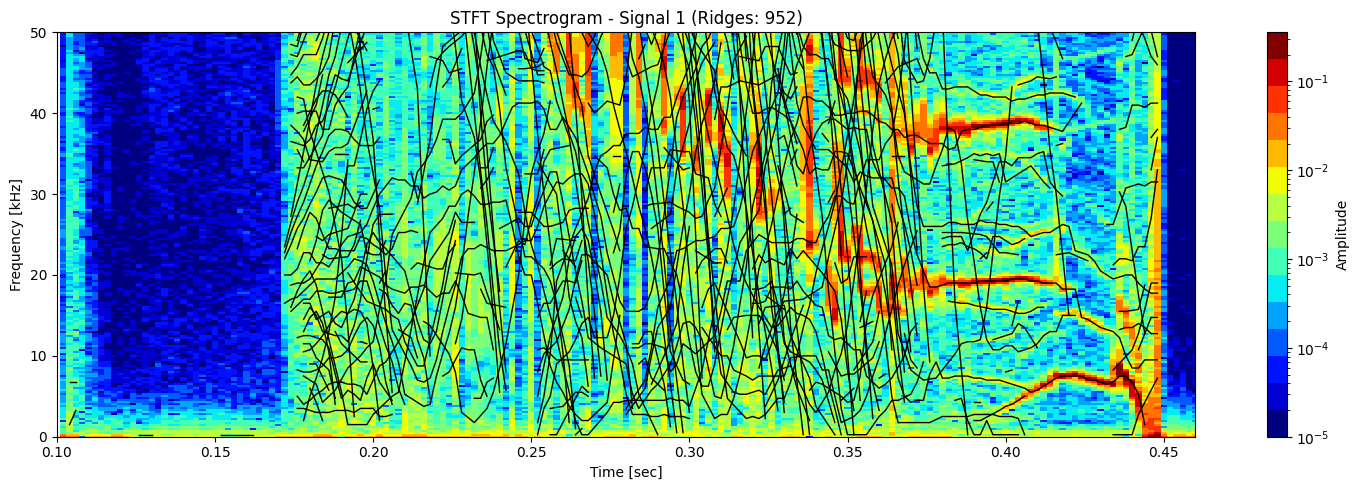

Processing signal 2/4
→ Number of ridges detected: 998


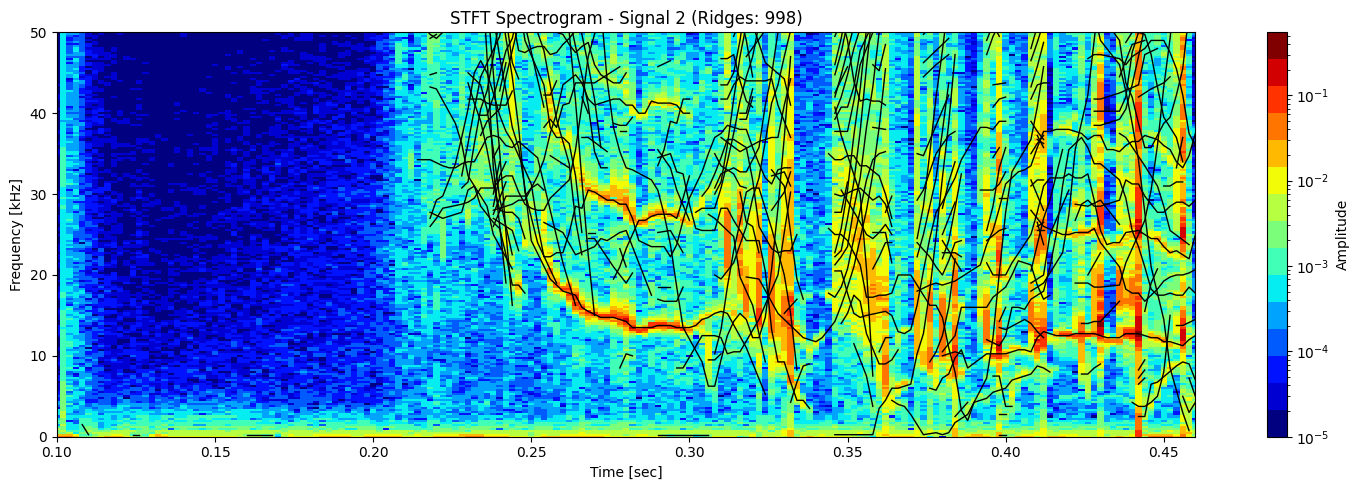

Processing signal 3/4
→ Number of ridges detected: 1381


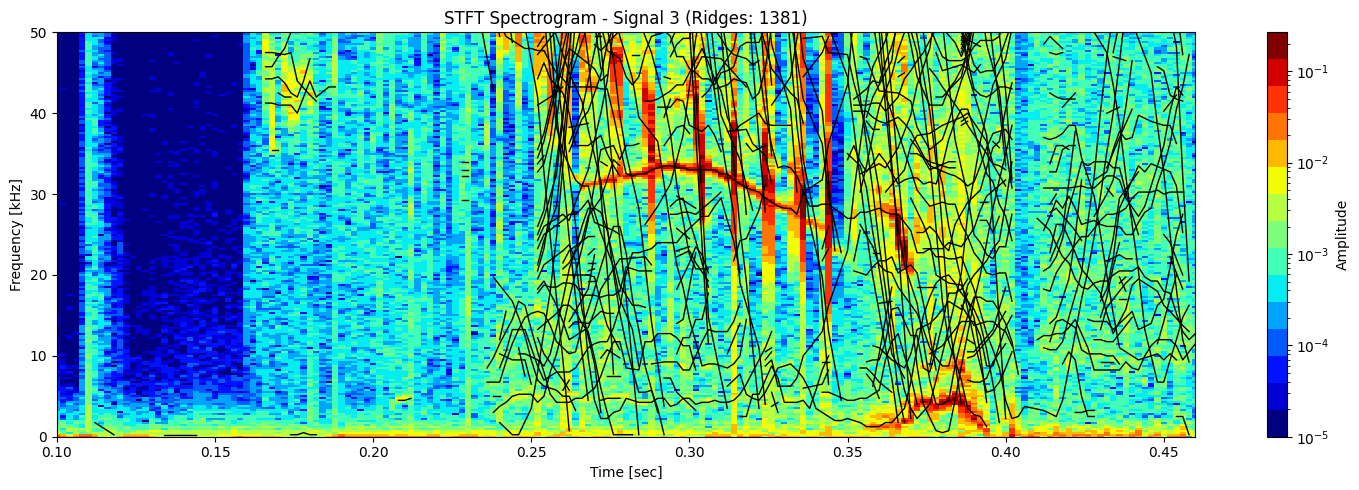

Processing signal 4/4
→ Number of ridges detected: 1825


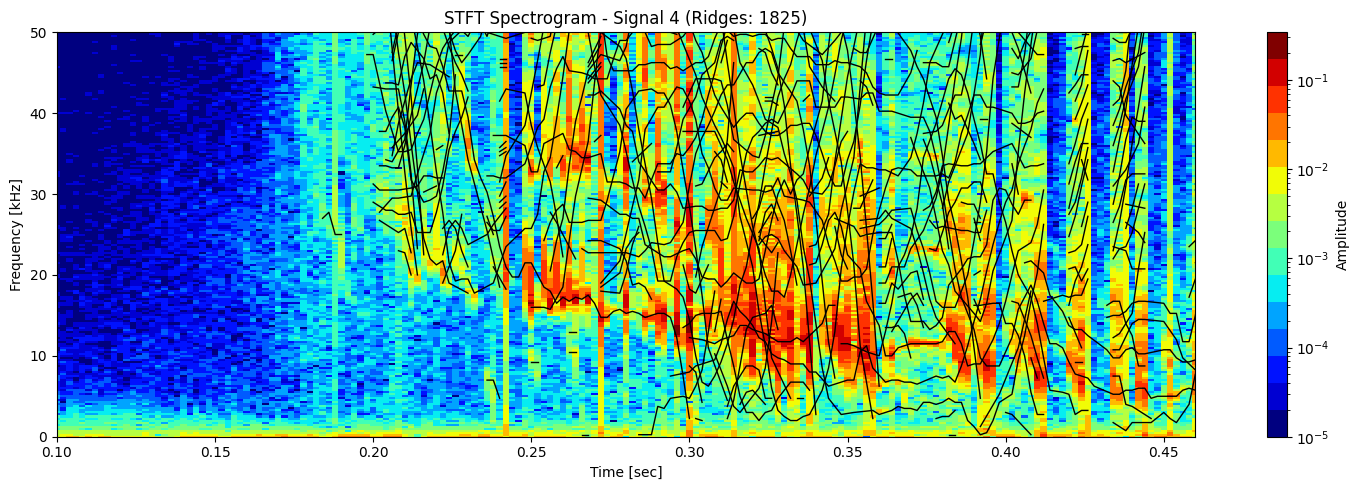

In [87]:
nperseg = 2000
nfft = 2000

for i, ds in enumerate(ds_list):
    print(f"Processing signal {i+1}/{len(ds_list)}")

    # Compute sample rate
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])

    # Compute STFT
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    # Extract ridges
    # ridges = extract_denoised_ridges_from_stft(Zxx, f, t)
    ridges = extract_denoised_ridges_from_stft(
    Zxx, f, t,
    fixed_amp_thresh=1e-3,
    delta_f_max=4000,
    min_ridge_len=2,
    min_avg_amp=1e-4
)


    # Print ridge count
    print(f"→ Number of ridges detected: {len(ridges)}")

    # Plot
    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap('jet', 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, 50)
    ax.set_xlim(0.1, 0.46)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(f"STFT Spectrogram - Signal {i+1} (Ridges: {len(ridges)})")
    fig.colorbar(cax, ax=ax, label='Amplitude')
    plot_ridges_on_spectrogram(ridges, ax, color='black')
    plt.tight_layout()
    plt.show()
